# 📌 Credit Risk Prediction for Loan Approval  

This notebook demonstrates an **end-to-end machine learning project** for predicting **loan default risk**.  
The goal is to help financial institutions identify **high-risk loan applicants** and make better lending decisions.  

### 🔍 Steps Covered in this Notebook:
1. **Data Wrangling & Cleaning**  
   - Handle missing values  
   - Drop low-information and high-unique columns  
   - Encode categorical variables  
   - Feature scaling and binning  

2. **Exploratory Data Analysis (EDA)**  
   - Distribution of loan status  
   - Risk patterns across loan amount, purpose, and applicant features  
   - Visual insights using Matplotlib & Seaborn  

3. **Feature Engineering**  
   - Created derived features (e.g., loan amount bins)  
   - Handled categorical variables with one-hot encoding  

4. **Modeling & Optimization**  
   - Trained multiple models (Logistic Regression, Random Forest, LightGBM)  
   - Final model: **LightGBM Classifier** (chosen for efficiency & performance)  
   - Hyperparameter tuning with **Optuna Bayesian Optimization**  

5. **Model Evaluation & Explainability**  
   - Metrics: Accuracy, ROC-AUC, Confusion Matrix  
   - SHAP values for model interpretability  
   - Insights into key features driving loan defaults  

6. **Visualization & Insights**  
   - Loan default trends by purpose and loan amount  
   - Risk segmentation plots   

### ✅ Outcome:
- Achieved **97% accuracy** with LightGBM  
- Built interpretable and scalable solution for credit risk assessment  
- Delivered actionable insights for **data-driven financial decision-making**  

---


In [ ]:
# Import libraries
# !pip install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split

import optuna
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import shap

import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.filterwarnings("ignore")

# Data Preparation

In [2]:
def wrangle(filepath):
    df=pd.read_csv(filepath) # read the csv file
    return df

df=wrangle("loan.csv")

**Explore the Data.**

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(887379, 74)

In [5]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [7]:
df.isnull().sum()  # Check the total null values

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            866007
total_rev_hi_lim     70276
inq_fi              866007
total_cu_tl         866007
inq_last_12m        866007
Length: 74, dtype: int64

In [8]:
print("Duplicate Rows", df.duplicated().sum()) # Check the duplicae rows

Duplicate Rows 0


In [9]:
df.nunique()  # Check the unique  values

id                  887379
member_id           887379
loan_amnt             1372
funded_amnt           1372
funded_amnt_inv       9856
                     ...  
all_util              1128
total_rev_hi_lim     21251
inq_fi                  18
total_cu_tl             33
inq_last_12m            29
Length: 74, dtype: int64

# Data cleaning

**Handle meaningless columns**

In [10]:
# Drop meaningless columns
df.drop(columns=['id', 'member_id', 'url', 'desc', 'title', 'zip_code'], inplace=True)

print("New Dataset Shape:", df.shape)

New Dataset Shape: (887379, 68)


**If a column has too many unique values(e.g.,issue_d with 800k+ unique values), it's likely an identifier or timestamp, which is not**
**useful. If a column has only 1 or 2 unique values, it doesn't provide enough information for prediction.** 

In [11]:
# Set threshold for dropping columns
high_unique_threshold=df.shape[0]*0.8  # If > 80% of rows are unique, drop it
low_unique_threshold=1  # if only 1 unique value, drop it

# Identify columns to drop 
high_unique_cols= [col for col in df.columns if df[col].nunique() > high_unique_threshold]
low_unique_cols= [col for col in df.columns if df[col].nunique() <= low_unique_threshold]

# Drop those columns
df.drop(columns= high_unique_cols + low_unique_cols, inplace=True)

print("Dropped high-unique columns:", high_unique_cols)
print("Dropped low-unique columns:", low_unique_cols)
print("New dataset shape:", df.shape)

Dropped high-unique columns: []
Dropped low-unique columns: ['policy_code']
New dataset shape: (887379, 67)


In [12]:
# Display remaining columns
print("Remaining columns:", df.columns)

Remaining columns: Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal',

**Handle missing columns**

* To many missing values(>80%) --> Drop the entire column (industry standard threshold 80%).
* Moderate missing values(10-80%) --> Impute using median (numerical) and mode(categorical).
* Few missing values (<10%) --> Drop rows (if very few) or impute.

In [13]:
# Define threshold 80% missing values
missing_threshold=0.8
missing_percent=df.isnull().sum() / len(df)
cols_to_drop= missing_percent[missing_percent > missing_threshold].index

# Drop columns
df.drop(columns=cols_to_drop, inplace=True)

print("Dropped columns due to high missing values (>80% missing):", list(cols_to_drop))
print("New dataset shape:", df.shape)


Dropped columns due to high missing values (>80% missing): ['mths_since_last_record', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']
New dataset shape: (887379, 49)


In [14]:
# Identify numerical and categorical columns with missing values (10-80%)
missing_percent=df.isnull().sum() / len(df)
moderate_missing_cols= missing_percent[(missing_percent > 0.1) & (missing_percent <= 0.8)].index

# Seperate numerical & categorical
num_missing_cols= [col for col in moderate_missing_cols if df[col].dtype in ['int64', 'float64']]
cat_missing_cols= [col for col in moderate_missing_cols if df[col].dtype == 'object']

# Impute numerical with median
for col in num_missing_cols:
    df[col].fillna(df[col].median(), inplace=True)
    
# Impute categorical with mode
for col in cat_missing_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
    
print("Imputed numerical columns (median)", num_missing_cols)
print("Imputed categorical columns (mode)", cat_missing_cols)

Imputed numerical columns (median) ['mths_since_last_delinq', 'mths_since_last_major_derog']
Imputed categorical columns (mode) ['next_pymnt_d']


**For small amounts of missing data, the best approach depends on:**

* If it's <5%, we drop rows.
* If it's 5-10%, we impute based on distribution.

In [15]:
# Identify columns with <10% missing values
few_missing_cols= missing_percent[(missing_percent > 0) & (missing_percent <= 0.1)].index

# Drop rows with missing values in these columns
df.dropna(subset= few_missing_cols, inplace=True)

print("Dropped rows with missing values in these columns (<10% missing):", list(few_missing_cols))
print("New dataset shape:", df.shape)

Dropped rows with missing values in these columns (<10% missing): ['emp_title', 'emp_length', 'annual_inc', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'last_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
New dataset shape: (752953, 49)


In [16]:
# Check remaining missing values
print("Remaining missing values:", df.isnull().sum().sum())

Remaining missing values: 0


# Exploratory Data Analysis (EDA)

**Target variable imbalance check**

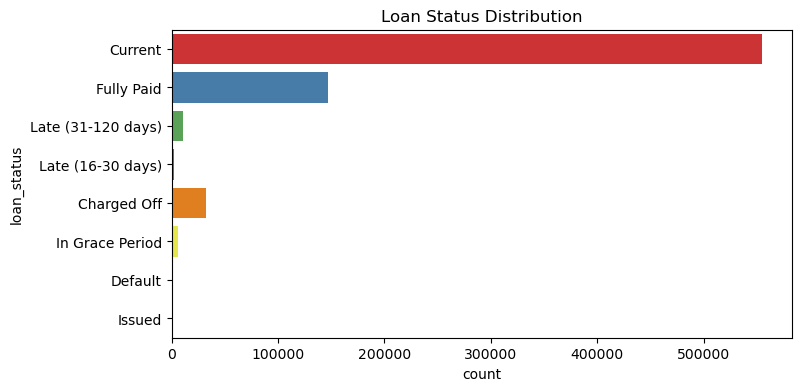

In [39]:
# Plot loan status distribution
plt.figure(figsize=(8,4))
sns.countplot(y=df['loan_status'], palette='Set1')
plt.title("Loan Status Distribution")
plt.show()

In [40]:
# Print loan distribution percentage
print(df['loan_status'].value_counts(normalize=True)*100)

loan_status
Current               73.666882
Fully Paid            19.461374
Charged Off            4.274370
Late (31-120 days)     1.402744
In Grace Period        0.758879
Late (16-30 days)      0.282621
Default                0.147818
Issued                 0.005312
Name: proportion, dtype: float64


**We divide loan_status into 5 risk categories:**

* 0 - Fully Paid (Low Risk)
* 1 - Low Risk (Minor Delays)
* 2 - Medium Risk (Moderate Delays)
* 3 - High Risk (Defaulted)
* 4 - Active Loan (No Decision Yet) We'll remove "Current" and "Issued" loans (since we can't determine their final status), then reassign categories.

In [41]:
# Define loan status categories
loan_status_mapping = {
    'Fully Paid': 0,  # Fully repaid loans
    'In Grace Period': 1,  # Borrowers with minor late payments
    'Late (16-30 days)': 1,  # Short delay
    'Late (31-120 days)': 2,  # Moderate delay
    'Charged Off': 3,  # Officially defaulted
    'Default': 3,  # Severe default case
    'Current': 4,  # Ongoing loan (remove these)
    'Issued': 4  # New loans (remove these)
}

# Map the values
df['loan_status'] = df['loan_status'].map(loan_status_mapping)

In [42]:
# Drop rows where loan_status = 4 (Current or Issued, since we can't predict these)
df = df[df['loan_status'] != 4]

# Convert to integer type
df['loan_status'] = df['loan_status'].astype(int)

# Check the new distribution
print(df['loan_status'].value_counts(normalize=True) * 100)

loan_status
0    73.919470
3    16.796646
2     5.327993
1     3.955891
Name: proportion, dtype: float64


**Feature Distributions Analysis**

**We will focus on key financial and credit-related numerical variables:**

* Loan Features: loan_amnt, funded_amnt, int_rate, installment
* Income & Debt Features: annual_inc, dti, revol_bal
* Credit History Features: open_acc, total_acc, pub_rec

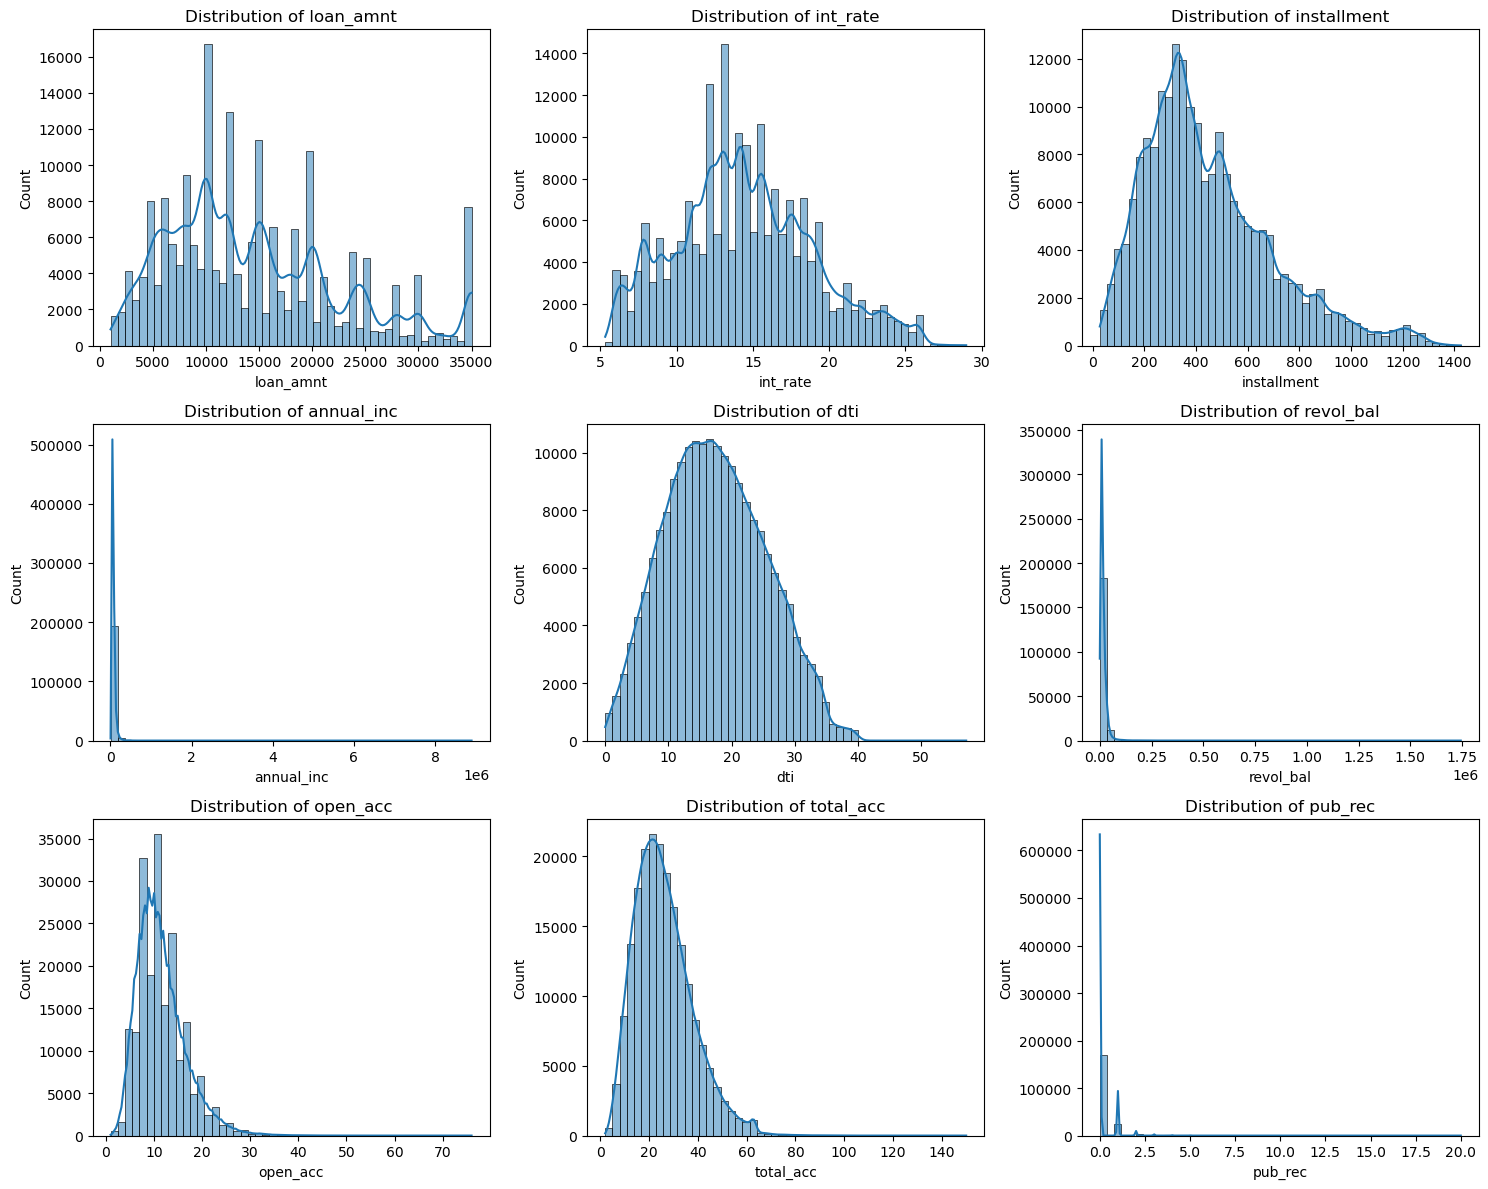

In [43]:
# Select important numerical columns
num_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 'open_acc', 'total_acc', 'pub_rec']

# Plot distributions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

In [44]:
# Describe numerical features (before transformation)
num_summary = df[num_cols].describe().T

# Calculate Skewness
num_summary['skewness'] = df[num_cols].skew()

# Calculate percentage of outliers (1.5*IQR method)
outlier_counts = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_counts[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum() / len(df) * 100

# Add outlier percentages to the summary
num_summary['outlier_percentage'] = num_summary.index.map(outlier_counts)

print(num_summary)

                count          mean           std      min         25%  \
loan_amnt    198236.0  14462.391291   8253.248565  1000.00   8000.0000   
int_rate     198236.0     14.392810      4.454606     5.32     11.1400   
installment  198236.0    445.236683    247.116686    27.85    268.0575   
annual_inc   198236.0  74626.504693  62367.075058  6000.00  46800.0000   
dti          198236.0     17.527758      7.941859     0.00     11.5700   
revol_bal    198236.0  15745.765285  19455.252293     0.00   6300.0000   
open_acc     198236.0     11.470273      5.019311     1.00      8.0000   
total_acc    198236.0     25.961400     11.820545     2.00     17.0000   
pub_rec      198236.0      0.174888      0.488575     0.00      0.0000   

                  50%       75%         max   skewness  outlier_percentage  
loan_amnt    12350.00  20000.00    35000.00   0.750161            0.000000  
int_rate        14.09     17.56       28.99   0.303218            0.060029  
installment    391.56    580

* loan_amnt 0.75 (Moderate) 0.00% ✅ No Fix Needed
* int_rate 0.30 (Slight) 0.06% ✅ No Fix Needed
* installment 0.96 (Moderate) 2.64% ❌ Cap Outliers
* annual_inc 51.64 (Extreme) 4.23% 🚨 Log Transform
* dti 0.20 (Small) 0.00% ✅ No Fix Needed
* revol_bal 12.70 (Extreme) 5.03% 🚨 Log Transform
* open_acc 1.19 (Moderate) 2.51% ❌ Cap Outliers
* total_acc 0.82 (Moderate) 1.56% ✅ No Fix Needed
* pub_rec 4.91 (Extreme) 14.63% 🚨 Cap Outliers

In [45]:
# Apply log transformation (add 1 to avoid log(0) issues)
df['annual_inc'] = np.log1p(df['annual_inc'])
df['revol_bal'] = np.log1p(df['revol_bal'])

# Define function for IQR-based capping
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

# Apply outlier capping to selected features
outlier_cols = ['installment', 'open_acc']
for col in outlier_cols:
    df = cap_outliers(df, col)

print("Applied log transformation & capped extreme outliers.")

Applied log transformation & capped extreme outliers.


In [46]:
# Check distribution of pub_rec
pub_rec_counts = df['pub_rec'].value_counts(normalize=True) * 100
print("Distribution of pub_rec:\n", pub_rec_counts)

# If >95% of values are zero, drop the column
if pub_rec_counts.iloc[0] > 95:
    df.drop(columns=['pub_rec'], inplace=True)
    print("Dropped 'pub_rec' due to extreme imbalance.")
else:
    # Convert to binary: 0 (No public record) / 1 (Has public record)
    df['pub_rec'] = df['pub_rec'].apply(lambda x: 1 if x > 0 else 0)
    print("Converted 'pub_rec' into a binary feature (0 = No record, 1 = Has record).")

Distribution of pub_rec:
 pub_rec
0.0     85.372990
1.0     12.729272
2.0      1.339817
3.0      0.354628
4.0      0.107952
5.0      0.047923
6.0      0.025222
7.0      0.009080
8.0      0.004540
9.0      0.003027
10.0     0.002522
12.0     0.001009
11.0     0.001009
20.0     0.000504
15.0     0.000504
Name: proportion, dtype: float64
Converted 'pub_rec' into a binary feature (0 = No record, 1 = Has record).


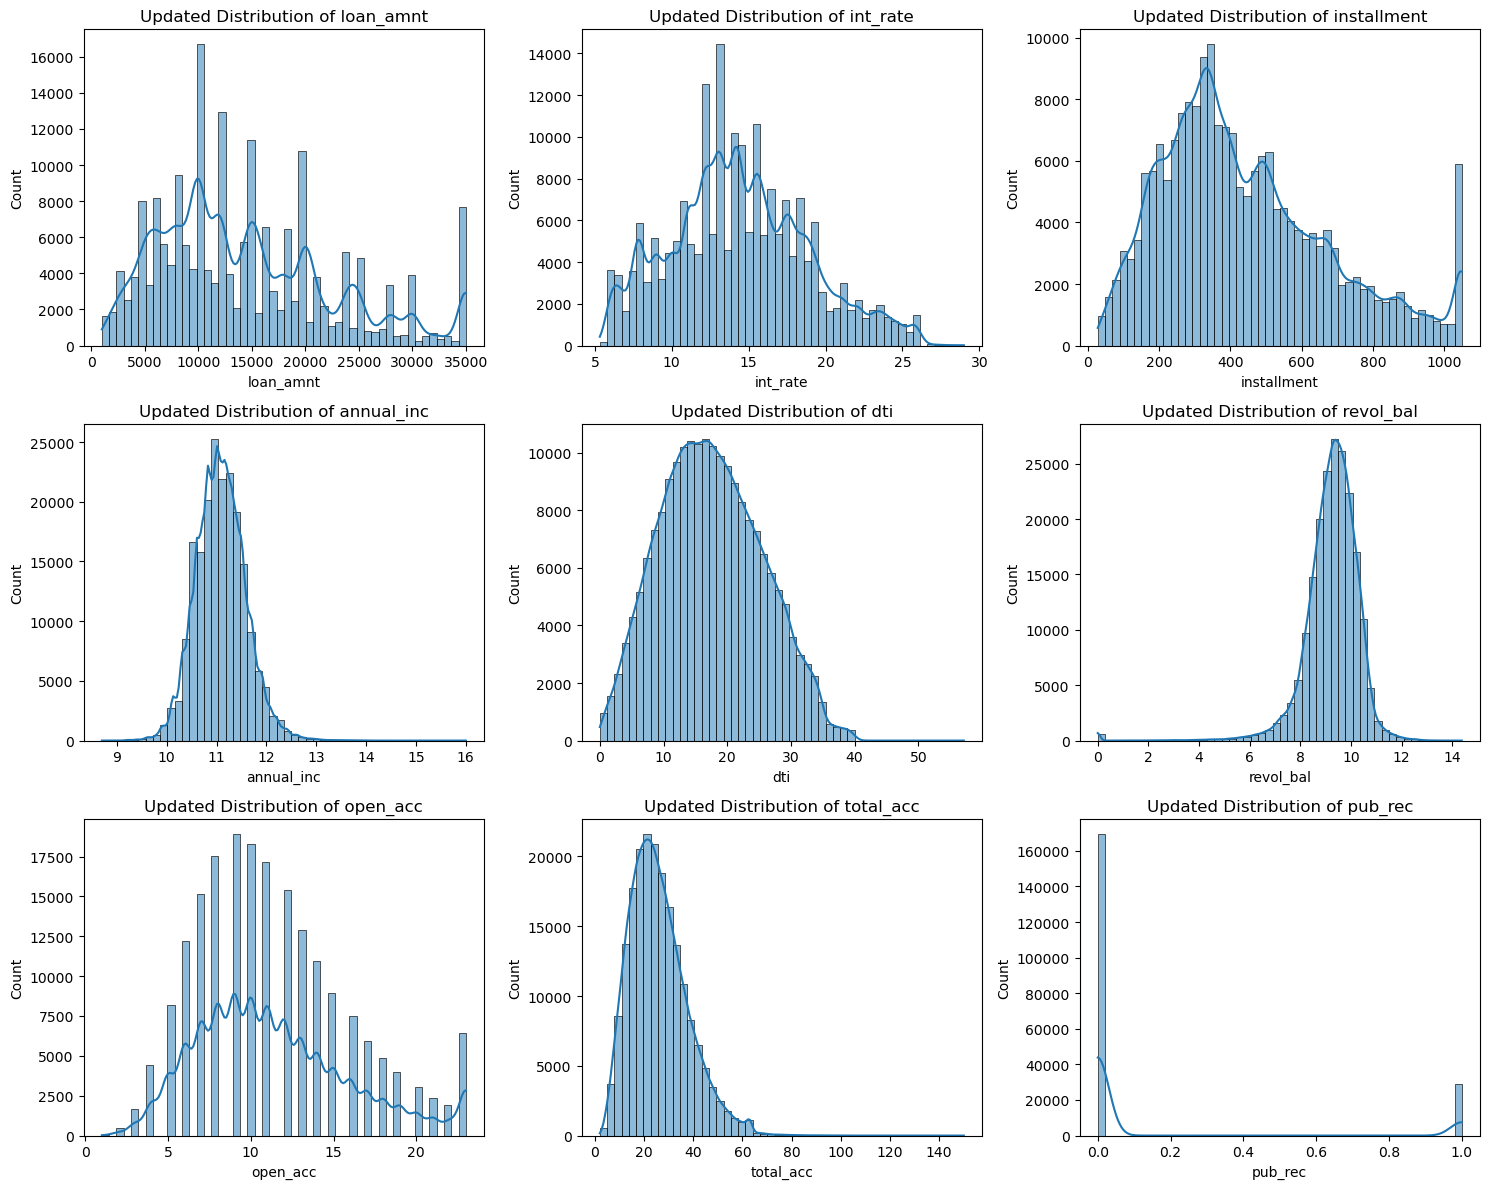

In [47]:
# Replot updated distributions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):  # Fix: Use enumerate() correctly
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Updated Distribution of {col}")

plt.tight_layout()
plt.show()

**Categorical Features Analysis**

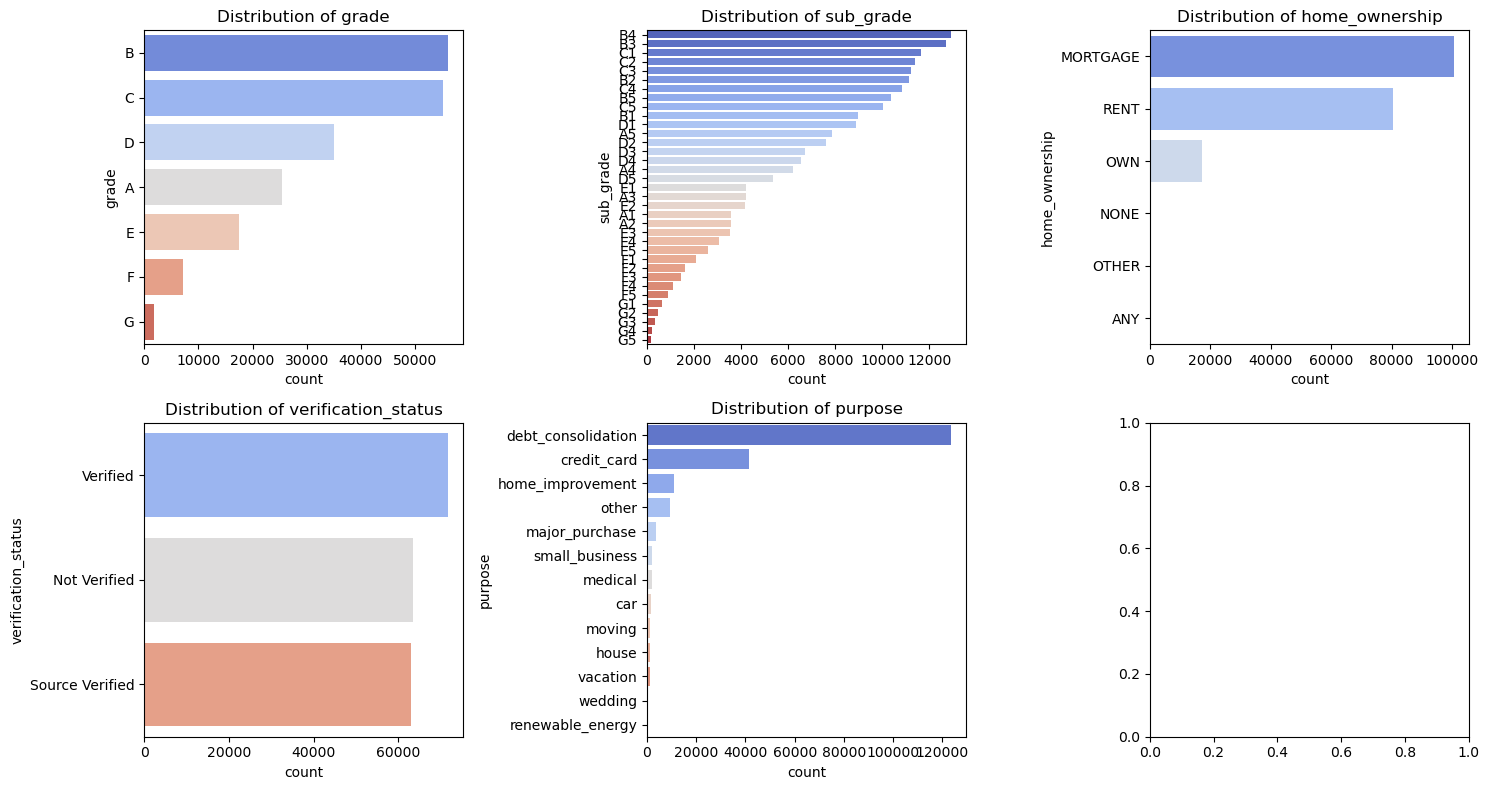

In [48]:
cat_cols = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose']

# Plot bar charts for categorical variables
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(y=df[col], order=df[col].value_counts().index, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

In [49]:
print(df['term'].unique())

[' 36 months' ' 60 months']


**Data Encoding**

In [50]:
# Ordinal Encoding for Grade & Sub-Grade
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade'] = df['grade'].map(grade_map)

# Convert sub_grade (A1, A2, B1...) into ordered numbers
df['sub_grade'] = df['sub_grade'].str.extract('(\d+)').astype(float)

# Convert 'term' (e.g., '36 months' → 36)
df['term'] = df['term'].str.extract('(\d+)').astype(int)

# Label Encode Employment Length (e.g., '10+ years' → 10)
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
df['emp_length'].fillna(df['emp_length'].median(), inplace=True)  # Replace NaNs with median

# One-Hot Encoding for Other Categorical Features
one_hot_cols = ['home_ownership', 'verification_status', 'purpose']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)  # Drop first to avoid multicollinearity

print("Categorical variables encoded successfully.")

Categorical variables encoded successfully.


**Feature Scaling**

* Since we have skewed data (e.g., annual_inc), we'll use RobustScaler

In [51]:
# Select numerical columns to scale
num_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 'open_acc', 'total_acc']

# Apply RobustScaler
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Feature scaling applied using RobustScaler.")

Feature scaling applied using RobustScaler.


In [52]:
df[num_cols].describe()

,loan_amnt,int_rate,installment,annual_inc,dti,revol_bal,open_acc,total_acc
count,198236.000000,198236.000000,198236.000000,198236.000000,198236.000000,198236.000000,198236.000000,198236.000000
mean,0.176033,0.047167,0.160629,0.005508,0.035983,-0.085947,0.059535,0.122587
std,0.687771,0.693864,0.759025,0.758923,0.684053,0.951748,0.774412,0.738784
min,-0.945833,-1.366044,-1.164273,-3.643397,-1.473730,-8.209647,-1.666667,-1.375000
25%,-0.362500,-0.459502,-0.395344,-0.502355,-0.477175,-0.519266,-0.500000,-0.437500
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.637500,0.540498,0.604656,0.497645,0.522825,0.480734,0.500000,0.562500
max,1.887500,2.320872,2.104656,7.522999,3.447890,4.423491,2.000000,7.875000


In [53]:
# Find non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Categorical Columns:", non_numeric_cols.tolist())

Categorical Columns: ['emp_title', 'issue_d', 'pymnt_plan', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding']


In [54]:
# Drop `emp_title` (Too many unique values, job title isn’t structured well)
df.drop(columns=['emp_title'], inplace=True)

# Convert Date Features into time-based numerical values
date_features = ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line']

# Convert dates to datetime format
for col in date_features:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Create new feature: Number of months since earliest credit line
df['credit_age'] = (df['issue_d'] - df['earliest_cr_line']).dt.days / 30

# Convert `issue_d` to numerical (Number of months since first issue date)
df['months_since_issue'] = (df['issue_d'] - df['issue_d'].min()).dt.days / 30

# Drop raw date columns
df.drop(columns=date_features, inplace=True)

# Label Encoding for Binary Features
binary_features = ['pymnt_plan', 'initial_list_status', 'application_type']

for col in binary_features:
    df[col] = LabelEncoder().fit_transform(df[col])

# One-Hot Encoding for `addr_state` (Many unique values)
df = pd.get_dummies(df, columns=['addr_state'], drop_first=True)

print("Remaining categorical variables properly encoded.")

Remaining categorical variables properly encoded.


In [55]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 198236 entries, 42538 to 887369
Columns: 109 entries, loan_amnt to addr_state_WY
dtypes: bool(68), float64(34), int32(5), int64(2)
memory usage: 72.6 MB
None


**Compute & Visualize Correlation**

In [56]:
# Compute correlation matrix
corr_matrix = df.corr()

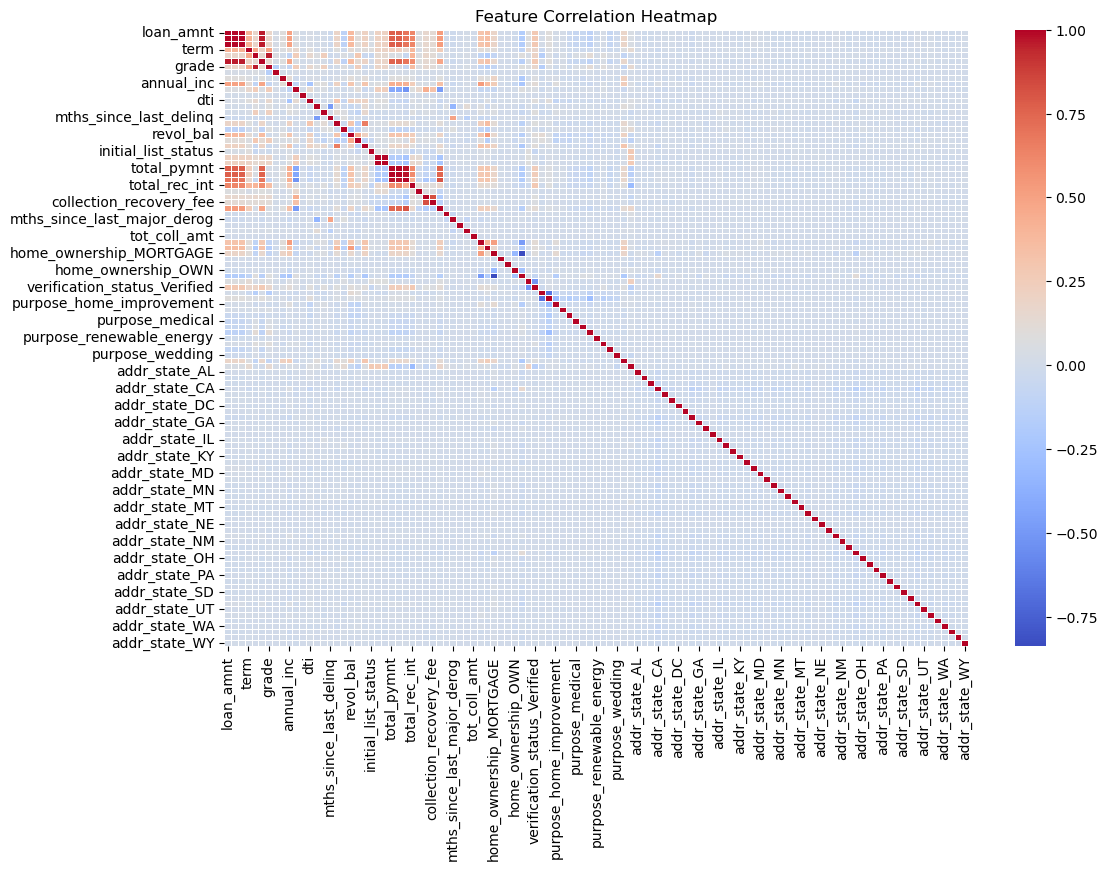

In [57]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [58]:
print(corr_matrix)

                 loan_amnt  funded_amnt  funded_amnt_inv      term  int_rate  \
loan_amnt         1.000000     1.000000         0.999994  0.417620  0.168548   
funded_amnt       1.000000     1.000000         0.999994  0.417620  0.168547   
funded_amnt_inv   0.999994     0.999994         1.000000  0.417663  0.168735   
term              0.417620     0.417620         0.417663  1.000000  0.466260   
int_rate          0.168548     0.168547         0.168735  0.466260  1.000000   
...                    ...          ...              ...       ...       ...   
addr_state_VT    -0.006396    -0.006396        -0.006404 -0.001862 -0.001717   
addr_state_WA     0.001663     0.001663         0.001653 -0.004999 -0.001860   
addr_state_WI    -0.008083    -0.008083        -0.008078 -0.000056 -0.004530   
addr_state_WV     0.000152     0.000152         0.000147  0.008209 -0.000706   
addr_state_WY     0.008513     0.008513         0.008504  0.002562 -0.001774   

                 installment     grade 

* Perfect Correlation (1.00) between loan_amnt, funded_amnt, and funded_amnt_inv. These features are redundant and provide the same information.
* installment & loan_amnt (0.96) → Logical, as bigger loans mean bigger monthly payments.
* grade & int_rate (0.95) → Higher loan risk (lower grade) leads to higher interest rates.
* term & int_rate (0.47) → Longer loan terms tend to have higher interest rates.
* annual_inc & loan_amnt (0.50) → Higher income leads to larger loan approvals.
* Many addrstate* features have very low correlations (close to 0).

In [59]:
df.drop(columns=['funded_amnt', 'funded_amnt_inv'], inplace=True)
print("Dropped redundant features: funded_amnt, funded_amnt_inv")

Dropped redundant features: funded_amnt, funded_amnt_inv


In [60]:
df.drop(columns=[col for col in df.columns if 'addr_state_' in col], inplace=True)
print("Dropped addr_state features to reduce dimensionality")

Dropped addr_state features to reduce dimensionality


**Split the Data for training & testing**

In [61]:
# Define features (X) and target (y)
X = df.drop(columns=['loan_status'])  # Drop target column
y = df['loan_status']

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train-test split complete. Training set size:", X_train.shape, "Test set size:", X_test.shape)

Train-test split complete. Training set size: (158588, 57) Test set size: (39648, 57)


# Model Building

**Optuna Test**

**Why use Optuna?**

**Hyperparameter Tuning Made Easy**

* LightGBM has many hyperparameters (n_estimators, learning_rate, num_leaves, max_depth, etc.).
* Choosing them manually (trial-and-error) is time-consuming and often suboptimal. Optuna automates this search.

**Bayesian Optimization (Smarter than Grid/Random Search)**

* Grid Search: tries all combinations → very slow.
* Random Search: tries random values → faster, but wasteful.
* Optuna (Bayesian): uses past trials to guess better hyperparameters → fewer trials, better results.

**Automatic Stopping**

* Optuna can stop unpromising trials early, saving compute.

**Reproducibility**

* Each trial is logged, so you know exactly which hyperparameters performed best.

**Performance Boost**

* Well-tuned hyperparameters often improve:
  * Higher accuracy / F1-score
  * Lower overfitting
  * Faster training

In [62]:
# Define objective function for Bayesian Optimization
def objective(trial):
    # Suggest hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'class_weight': 'balanced'
    }
 # Split training data into train (80%) and validation (20%) **randomly**
    X_train_opt, X_valid, y_train_opt, y_valid = train_test_split(X_train, y_train, 
                                                                  test_size=0.2, 
                                                                  random_state=trial.suggest_int('random_state', 1, 100),
                                                                  stratify=y_train)  # Ensures class balance

    # Train LightGBM model
    model = lgb.LGBMClassifier(**params)
    
    model.fit(X_train_opt, y_train_opt, 
              eval_set=[(X_valid, y_valid)], 
              eval_metric="multi_logloss",  # Define evaluation metric
              callbacks=[early_stopping(50), log_evaluation(50)])  # Correct early stopping

    # Predict on validation set
    y_pred = model.predict(X_valid)

    # Evaluate using accuracy
    return accuracy_score(y_valid, y_pred)

In [63]:
# Run Optuna optimization (Bayesian Search)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-09-14 10:30:43,939] A new study created in memory with name: no-name-7b13ee44-d136-4e49-b8f2-972a897b57d8


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.294196
[100]	valid_0's multi_logloss: 0.119075
[150]	valid_0's multi_logloss: 0.079982
[200]	valid_0's multi_logloss: 0.0689986
[250]	valid_0's multi_logloss: 0.0651008
[300]	valid_0's multi_logloss: 0.062982
[350]	valid_0's multi_logloss: 0.0616353
[400]	valid_0's multi_logloss: 0.0606612
[450]	valid_0's multi_logloss: 0.060126
[500]	valid_0's multi_logloss: 0.0597871
[550]	valid_0's multi_logloss: 0.0595857
[600]	valid_0's multi_logloss: 0.059458
Did not meet early stopping. Best iteration is:
[600]	valid_0's multi_logloss: 0.059458


[I 2025-09-14 10:31:30,867] Trial 0 finished with value: 0.9765117598839775 and parameters: {'n_estimators': 600, 'learning_rate': 0.02166076607711143, 'num_leaves': 133, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.6628690938227164, 'colsample_bytree': 0.7930649891872126, 'reg_alpha': 1.5227637875599492e-06, 'reg_lambda': 7.929563571010659, 'random_state': 63}. Best is trial 0 with value: 0.9765117598839775.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0955618
[100]	valid_0's multi_logloss: 0.0786071
[150]	valid_0's multi_logloss: 0.0711299
[200]	valid_0's multi_logloss: 0.0670172
[250]	valid_0's multi_logloss: 0.0642958
[300]	valid_0's multi_logloss: 0.0622373
[350]	valid_0's multi_logloss: 0.0607515
[400]	valid_0's multi_logloss: 0.0597121
[450]	valid_0's multi_logloss: 0.0588733
[500]	valid_0's multi_logloss: 0.0582107
[550]	valid_0's multi_logloss: 0.0578933
[600]	valid_0's multi_logloss: 0.0576695
[650]	valid_0's multi_logloss: 0.0573708
[700]	valid_0's multi_logloss: 0.057054
[750]	valid_0's multi_logloss: 0.0568388
[800]	valid_0's multi_logloss: 0.0566994
[850]	valid_0's multi_logloss: 0.0566503
[900]	valid_0's multi_logloss: 0.0566302
Early stopping, best iteration is:
[869]	valid_0's multi_logloss: 0.0565915


[I 2025-09-14 10:32:04,280] Trial 1 finished with value: 0.9790024591714483 and parameters: {'n_estimators': 937, 'learning_rate': 0.11973670951362114, 'num_leaves': 116, 'max_depth': 4, 'min_child_samples': 35, 'subsample': 0.7278410956942463, 'colsample_bytree': 0.5743940764737812, 'reg_alpha': 1.5384497598469717, 'reg_lambda': 2.80311361544831e-07, 'random_state': 80}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.59828
[100]	valid_0's multi_logloss: 0.310278
[150]	valid_0's multi_logloss: 0.181515
[200]	valid_0's multi_logloss: 0.121515
[250]	valid_0's multi_logloss: 0.0925679
[300]	valid_0's multi_logloss: 0.0780313
[350]	valid_0's multi_logloss: 0.0703333
[400]	valid_0's multi_logloss: 0.065946
[450]	valid_0's multi_logloss: 0.0634335
Did not meet early stopping. Best iteration is:
[467]	valid_0's multi_logloss: 0.0628121


[I 2025-09-14 10:32:35,159] Trial 2 finished with value: 0.9757866195850936 and parameters: {'n_estimators': 467, 'learning_rate': 0.010204125834212298, 'num_leaves': 115, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.8252599561539277, 'colsample_bytree': 0.6856577989374204, 'reg_alpha': 0.001258978530808332, 'reg_lambda': 0.0021830753575188197, 'random_state': 17}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.311062
[100]	valid_0's multi_logloss: 0.128554
[150]	valid_0's multi_logloss: 0.0865789
[200]	valid_0's multi_logloss: 0.0741513
[250]	valid_0's multi_logloss: 0.0689724
[300]	valid_0's multi_logloss: 0.0662123
[350]	valid_0's multi_logloss: 0.0641085
Did not meet early stopping. Best iteration is:
[374]	valid_0's multi_logloss: 0.0633152


[I 2025-09-14 10:32:55,489] Trial 3 finished with value: 0.9761018979759127 and parameters: {'n_estimators': 374, 'learning_rate': 0.020731457190211043, 'num_leaves': 87, 'max_depth': 10, 'min_child_samples': 72, 'subsample': 0.8978938196196418, 'colsample_bytree': 0.9888626465450385, 'reg_alpha': 5.454101376777262e-07, 'reg_lambda': 9.458297058124359, 'random_state': 2}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0655315
[100]	valid_0's multi_logloss: 0.0630695
[150]	valid_0's multi_logloss: 0.0633006
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.0630584


[I 2025-09-14 10:33:04,711] Trial 4 finished with value: 0.9759127309414213 and parameters: {'n_estimators': 254, 'learning_rate': 0.18850123306093888, 'num_leaves': 77, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.6544031608832264, 'colsample_bytree': 0.8521496058846502, 'reg_alpha': 5.6603498364275175, 'reg_lambda': 1.1090258466953102, 'random_state': 91}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.262397
[100]	valid_0's multi_logloss: 0.112086
[150]	valid_0's multi_logloss: 0.0781443
[200]	valid_0's multi_logloss: 0.0690428
[250]	valid_0's multi_logloss: 0.0654742
[300]	valid_0's multi_logloss: 0.0636566
[350]	valid_0's multi_logloss: 0.0625001
[400]	valid_0's multi_logloss: 0.0616577
[450]	valid_0's multi_logloss: 0.0615294
[500]	valid_0's multi_logloss: 0.0613439
[550]	valid_0's multi_logloss: 0.0611566
[600]	valid_0's multi_logloss: 0.0611009
[650]	valid_0's multi_logloss: 0.0610163
Did not meet early stopping. Best iteration is:
[662]	valid_0's multi_logloss: 0.0609942


[I 2025-09-14 10:33:56,570] Trial 5 finished with value: 0.9764487042058138 and parameters: {'n_estimators': 688, 'learning_rate': 0.024592846532801187, 'num_leaves': 140, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.9169607769589478, 'colsample_bytree': 0.5525390115141865, 'reg_alpha': 1.2446575482565159, 'reg_lambda': 0.7760323670415104, 'random_state': 71}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0981821
[100]	valid_0's multi_logloss: 0.0621755
[150]	valid_0's multi_logloss: 0.058747
[200]	valid_0's multi_logloss: 0.0581278
[250]	valid_0's multi_logloss: 0.0583965
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.0580525


[I 2025-09-14 10:34:17,098] Trial 6 finished with value: 0.9782142631944006 and parameters: {'n_estimators': 839, 'learning_rate': 0.0469095087794648, 'num_leaves': 132, 'max_depth': 13, 'min_child_samples': 62, 'subsample': 0.9744915429402496, 'colsample_bytree': 0.9824695385089206, 'reg_alpha': 6.170029094276283e-08, 'reg_lambda': 0.0001440298440271797, 'random_state': 93}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.10878
[100]	valid_0's multi_logloss: 0.0881177
[150]	valid_0's multi_logloss: 0.0806417
[200]	valid_0's multi_logloss: 0.0759911
[250]	valid_0's multi_logloss: 0.0724998
[300]	valid_0's multi_logloss: 0.0699627
[350]	valid_0's multi_logloss: 0.0678985
[400]	valid_0's multi_logloss: 0.066283
Did not meet early stopping. Best iteration is:
[417]	valid_0's multi_logloss: 0.0657701


[I 2025-09-14 10:34:30,371] Trial 7 finished with value: 0.9765432877230594 and parameters: {'n_estimators': 417, 'learning_rate': 0.13718254187675213, 'num_leaves': 51, 'max_depth': 3, 'min_child_samples': 60, 'subsample': 0.9161647610204635, 'colsample_bytree': 0.6017814547346481, 'reg_alpha': 0.1612084058920437, 'reg_lambda': 0.21824832922790122, 'random_state': 26}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.348015
[100]	valid_0's multi_logloss: 0.144892
[150]	valid_0's multi_logloss: 0.0932156
[200]	valid_0's multi_logloss: 0.0779423
[250]	valid_0's multi_logloss: 0.0719692
[300]	valid_0's multi_logloss: 0.068735
Did not meet early stopping. Best iteration is:
[349]	valid_0's multi_logloss: 0.0664668


[I 2025-09-14 10:34:44,150] Trial 8 finished with value: 0.9747777287344725 and parameters: {'n_estimators': 349, 'learning_rate': 0.018607372594942106, 'num_leaves': 34, 'max_depth': 15, 'min_child_samples': 77, 'subsample': 0.93921350946165, 'colsample_bytree': 0.9042706432368576, 'reg_alpha': 0.002905894943053635, 'reg_lambda': 3.0639939404738717e-07, 'random_state': 30}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0795776
[100]	valid_0's multi_logloss: 0.0671019
[150]	valid_0's multi_logloss: 0.0628729
[200]	valid_0's multi_logloss: 0.0620447
Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 0.0620039


[I 2025-09-14 10:34:57,377] Trial 9 finished with value: 0.9759127309414213 and parameters: {'n_estimators': 532, 'learning_rate': 0.0859439940920611, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 60, 'subsample': 0.793270970792936, 'colsample_bytree': 0.5709702488621661, 'reg_alpha': 1.2042499555322165e-05, 'reg_lambda': 0.0014759258736521696, 'random_state': 6}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.105067
[100]	valid_0's multi_logloss: 0.0824435
[150]	valid_0's multi_logloss: 0.074142
[200]	valid_0's multi_logloss: 0.0698196
[250]	valid_0's multi_logloss: 0.0669083
[300]	valid_0's multi_logloss: 0.0650504
[350]	valid_0's multi_logloss: 0.0636253
[400]	valid_0's multi_logloss: 0.062726
[450]	valid_0's multi_logloss: 0.0618763
[500]	valid_0's multi_logloss: 0.061213
[550]	valid_0's multi_logloss: 0.0610187
[600]	valid_0's multi_logloss: 0.0608777
[650]	valid_0's multi_logloss: 0.0607935
Early stopping, best iteration is:
[640]	valid_0's multi_logloss: 0.0606939


[I 2025-09-14 10:35:28,567] Trial 10 finished with value: 0.9765432877230594 and parameters: {'n_estimators': 952, 'learning_rate': 0.075233086304693, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 39, 'subsample': 0.504873628606266, 'colsample_bytree': 0.5005656534339357, 'reg_alpha': 0.060615912359616005, 'reg_lambda': 1.8734364979613338e-08, 'random_state': 46}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.112236
[100]	valid_0's multi_logloss: 0.0771664
[150]	valid_0's multi_logloss: 0.070101
[200]	valid_0's multi_logloss: 0.0658999
[250]	valid_0's multi_logloss: 0.063393
[300]	valid_0's multi_logloss: 0.0620831
[350]	valid_0's multi_logloss: 0.0611618
[400]	valid_0's multi_logloss: 0.0608531
[450]	valid_0's multi_logloss: 0.0605975
[500]	valid_0's multi_logloss: 0.0607818
Early stopping, best iteration is:
[450]	valid_0's multi_logloss: 0.0605975


[I 2025-09-14 10:35:54,372] Trial 11 finished with value: 0.9771423166656157 and parameters: {'n_estimators': 960, 'learning_rate': 0.05087006194468157, 'num_leaves': 148, 'max_depth': 7, 'min_child_samples': 97, 'subsample': 0.7021344635460904, 'colsample_bytree': 0.7003269926794118, 'reg_alpha': 4.7010547324682076e-08, 'reg_lambda': 1.6433912219088014e-05, 'random_state': 97}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.13036
[100]	valid_0's multi_logloss: 0.0722436
[150]	valid_0's multi_logloss: 0.065001
[200]	valid_0's multi_logloss: 0.0616973
[250]	valid_0's multi_logloss: 0.0599679
[300]	valid_0's multi_logloss: 0.0589407
[350]	valid_0's multi_logloss: 0.058435
[400]	valid_0's multi_logloss: 0.058372
Early stopping, best iteration is:
[375]	valid_0's multi_logloss: 0.0582792


[I 2025-09-14 10:36:19,527] Trial 12 finished with value: 0.9779620404817454 and parameters: {'n_estimators': 792, 'learning_rate': 0.03948557376365264, 'num_leaves': 114, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.5650849267760616, 'colsample_bytree': 0.9886811509430041, 'reg_alpha': 7.210219956602153e-05, 'reg_lambda': 1.7335427815936623e-05, 'random_state': 80}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0822062
[100]	valid_0's multi_logloss: 0.0695614
[150]	valid_0's multi_logloss: 0.0648452
[200]	valid_0's multi_logloss: 0.0630269
[250]	valid_0's multi_logloss: 0.0628681
Early stopping, best iteration is:
[244]	valid_0's multi_logloss: 0.0627029


[I 2025-09-14 10:36:33,405] Trial 13 finished with value: 0.9767324547575509 and parameters: {'n_estimators': 834, 'learning_rate': 0.1030972787651341, 'num_leaves': 123, 'max_depth': 6, 'min_child_samples': 42, 'subsample': 0.997634287476828, 'colsample_bytree': 0.6729302377429367, 'reg_alpha': 1.1407030290077349e-08, 'reg_lambda': 4.0931502192868596e-06, 'random_state': 82}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.183181
[100]	valid_0's multi_logloss: 0.118624
[150]	valid_0's multi_logloss: 0.0991423
[200]	valid_0's multi_logloss: 0.0910903
[250]	valid_0's multi_logloss: 0.0863336
[300]	valid_0's multi_logloss: 0.0828937
[350]	valid_0's multi_logloss: 0.0804
[400]	valid_0's multi_logloss: 0.0781968
[450]	valid_0's multi_logloss: 0.0762468
[500]	valid_0's multi_logloss: 0.0745247
[550]	valid_0's multi_logloss: 0.0730293
[600]	valid_0's multi_logloss: 0.0718434
[650]	valid_0's multi_logloss: 0.070706
[700]	valid_0's multi_logloss: 0.0696489
[750]	valid_0's multi_logloss: 0.0688572
[800]	valid_0's multi_logloss: 0.0679434
Did not meet early stopping. Best iteration is:
[805]	valid_0's multi_logloss: 0.0678619


[I 2025-09-14 10:36:53,868] Trial 14 finished with value: 0.9748407844126363 and parameters: {'n_estimators': 805, 'learning_rate': 0.05437294450460318, 'num_leaves': 94, 'max_depth': 3, 'min_child_samples': 48, 'subsample': 0.7585430985958428, 'colsample_bytree': 0.7772779588917332, 'reg_alpha': 0.014435234402556509, 'reg_lambda': 1.269653139499574e-08, 'random_state': 55}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.152689
[100]	valid_0's multi_logloss: 0.0767845
[150]	valid_0's multi_logloss: 0.067542
[200]	valid_0's multi_logloss: 0.0637133
[250]	valid_0's multi_logloss: 0.0614053
[300]	valid_0's multi_logloss: 0.0600527
[350]	valid_0's multi_logloss: 0.059241
[400]	valid_0's multi_logloss: 0.0589354
[450]	valid_0's multi_logloss: 0.0589706
Early stopping, best iteration is:
[427]	valid_0's multi_logloss: 0.0589293


[I 2025-09-14 10:37:23,807] Trial 15 finished with value: 0.9772369001828615 and parameters: {'n_estimators': 900, 'learning_rate': 0.0354111535746676, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 94, 'subsample': 0.8269235148352699, 'colsample_bytree': 0.8756022928568356, 'reg_alpha': 0.00023486474178544738, 'reg_lambda': 4.910592697014105e-07, 'random_state': 100}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0746952
[100]	valid_0's multi_logloss: 0.0664657
[150]	valid_0's multi_logloss: 0.0620908
[200]	valid_0's multi_logloss: 0.0614233
[250]	valid_0's multi_logloss: 0.0616763
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.0611868


[I 2025-09-14 10:37:33,453] Trial 16 finished with value: 0.9767324547575509 and parameters: {'n_estimators': 719, 'learning_rate': 0.18959561005126874, 'num_leaves': 74, 'max_depth': 5, 'min_child_samples': 68, 'subsample': 0.6034859339654354, 'colsample_bytree': 0.9300517812080837, 'reg_alpha': 7.809924922639933e-06, 'reg_lambda': 0.00022354103002701753, 'random_state': 81}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0629752
[100]	valid_0's multi_logloss: 0.0628615
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.0612337


[I 2025-09-14 10:37:43,359] Trial 17 finished with value: 0.9758496752632575 and parameters: {'n_estimators': 708, 'learning_rate': 0.12023759224312831, 'num_leaves': 149, 'max_depth': 13, 'min_child_samples': 32, 'subsample': 0.692723694599213, 'colsample_bytree': 0.6383168666091973, 'reg_alpha': 1.4964816077286395e-07, 'reg_lambda': 0.00021329508173089366, 'random_state': 43}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0930732
[100]	valid_0's multi_logloss: 0.0703021
[150]	valid_0's multi_logloss: 0.0648928
[200]	valid_0's multi_logloss: 0.0627345
[250]	valid_0's multi_logloss: 0.0615901
[300]	valid_0's multi_logloss: 0.0611425
[350]	valid_0's multi_logloss: 0.0609104
[400]	valid_0's multi_logloss: 0.0607895
Early stopping, best iteration is:
[393]	valid_0's multi_logloss: 0.0607641


[I 2025-09-14 10:38:08,430] Trial 18 finished with value: 0.9767639825966328 and parameters: {'n_estimators': 998, 'learning_rate': 0.06131963481423958, 'num_leaves': 104, 'max_depth': 9, 'min_child_samples': 86, 'subsample': 0.8524901048723005, 'colsample_bytree': 0.7365222150786633, 'reg_alpha': 8.95295248859329, 'reg_lambda': 0.03139380529468684, 'random_state': 69}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.514346
[100]	valid_0's multi_logloss: 0.270271
[150]	valid_0's multi_logloss: 0.177568
[200]	valid_0's multi_logloss: 0.134638
[250]	valid_0's multi_logloss: 0.114193
[300]	valid_0's multi_logloss: 0.103984
[350]	valid_0's multi_logloss: 0.0974234
[400]	valid_0's multi_logloss: 0.0932648
[450]	valid_0's multi_logloss: 0.0898339
[500]	valid_0's multi_logloss: 0.0872424
[550]	valid_0's multi_logloss: 0.0850158
[600]	valid_0's multi_logloss: 0.0830488
[650]	valid_0's multi_logloss: 0.0813472
[700]	valid_0's multi_logloss: 0.0798022
[750]	valid_0's multi_logloss: 0.0782141
[800]	valid_0's multi_logloss: 0.0769536
[850]	valid_0's multi_logloss: 0.0759295
Did not meet early stopping. Best iteration is:
[879]	valid_0's multi_logloss: 0.07536


[I 2025-09-14 10:38:36,287] Trial 19 finished with value: 0.972539252159657 and parameters: {'n_estimators': 879, 'learning_rate': 0.014584635043979994, 'num_leaves': 109, 'max_depth': 4, 'min_child_samples': 52, 'subsample': 0.9878517957336375, 'colsample_bytree': 0.8237221861940405, 'reg_alpha': 0.4266691756171951, 'reg_lambda': 1.7730992868426383e-07, 'random_state': 87}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.177797
[100]	valid_0's multi_logloss: 0.0890533
[150]	valid_0's multi_logloss: 0.0753927
[200]	valid_0's multi_logloss: 0.0702962
[250]	valid_0's multi_logloss: 0.0669149
[300]	valid_0's multi_logloss: 0.0647489
[350]	valid_0's multi_logloss: 0.0632885
[400]	valid_0's multi_logloss: 0.0622536
[450]	valid_0's multi_logloss: 0.0615237
[500]	valid_0's multi_logloss: 0.0609932
[550]	valid_0's multi_logloss: 0.0607352
[600]	valid_0's multi_logloss: 0.0606861
Early stopping, best iteration is:
[577]	valid_0's multi_logloss: 0.0606111


[I 2025-09-14 10:39:06,492] Trial 20 finished with value: 0.9770162053092881 and parameters: {'n_estimators': 634, 'learning_rate': 0.03343787056102041, 'num_leaves': 133, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.75937885112791, 'colsample_bytree': 0.7382805118026492, 'reg_alpha': 0.017918756009095083, 'reg_lambda': 6.636797043990952e-06, 'random_state': 74}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.16119
[100]	valid_0's multi_logloss: 0.0770747
[150]	valid_0's multi_logloss: 0.0666295
[200]	valid_0's multi_logloss: 0.0628585
[250]	valid_0's multi_logloss: 0.0603739
[300]	valid_0's multi_logloss: 0.0591324
[350]	valid_0's multi_logloss: 0.0584397
[400]	valid_0's multi_logloss: 0.0582166
[450]	valid_0's multi_logloss: 0.0583527
Early stopping, best iteration is:
[418]	valid_0's multi_logloss: 0.0581571


[I 2025-09-14 10:39:35,483] Trial 21 finished with value: 0.9770162053092881 and parameters: {'n_estimators': 781, 'learning_rate': 0.033816263011319875, 'num_leaves': 118, 'max_depth': 8, 'min_child_samples': 35, 'subsample': 0.550823483898471, 'colsample_bytree': 0.9962902822635626, 'reg_alpha': 0.00013066139794106794, 'reg_lambda': 3.850137988086381e-05, 'random_state': 59}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.122166
[100]	valid_0's multi_logloss: 0.0665266
[150]	valid_0's multi_logloss: 0.0608771
[200]	valid_0's multi_logloss: 0.0590997
[250]	valid_0's multi_logloss: 0.0586524
[300]	valid_0's multi_logloss: 0.0585555
Early stopping, best iteration is:
[287]	valid_0's multi_logloss: 0.0584687


[I 2025-09-14 10:39:57,901] Trial 22 finished with value: 0.9772053723437796 and parameters: {'n_estimators': 886, 'learning_rate': 0.03984642255194973, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.6145268493409821, 'colsample_bytree': 0.952192852089831, 'reg_alpha': 1.0247100371112365e-05, 'reg_lambda': 1.5883117343580858e-06, 'random_state': 78}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0808959
[100]	valid_0's multi_logloss: 0.0652708
[150]	valid_0's multi_logloss: 0.0614406
[200]	valid_0's multi_logloss: 0.0601062
[250]	valid_0's multi_logloss: 0.059992
Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.0598471


[I 2025-09-14 10:40:13,906] Trial 23 finished with value: 0.9778359291254177 and parameters: {'n_estimators': 759, 'learning_rate': 0.0690031754634563, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.5527402638978803, 'colsample_bytree': 0.9437112850148286, 'reg_alpha': 4.8693915367442695e-05, 'reg_lambda': 6.551681595525088e-05, 'random_state': 89}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.248418
[100]	valid_0's multi_logloss: 0.120381
[150]	valid_0's multi_logloss: 0.0944725
[200]	valid_0's multi_logloss: 0.0852226
[250]	valid_0's multi_logloss: 0.0803169
[300]	valid_0's multi_logloss: 0.0764754
[350]	valid_0's multi_logloss: 0.0736014
[400]	valid_0's multi_logloss: 0.0713837
[450]	valid_0's multi_logloss: 0.0693614
[500]	valid_0's multi_logloss: 0.0676967
[550]	valid_0's multi_logloss: 0.0663423
[600]	valid_0's multi_logloss: 0.0652841
[650]	valid_0's multi_logloss: 0.0643485
[700]	valid_0's multi_logloss: 0.0634535
[750]	valid_0's multi_logloss: 0.0627673
[800]	valid_0's multi_logloss: 0.0621722
[850]	valid_0's multi_logloss: 0.0615931
Did not meet early stopping. Best iteration is:
[862]	valid_0's multi_logloss: 0.0614608


[I 2025-09-14 10:40:44,184] Trial 24 finished with value: 0.9769531496311242 and parameters: {'n_estimators': 863, 'learning_rate': 0.027854769909693787, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 53, 'subsample': 0.7232580975260323, 'colsample_bytree': 0.8983486545763886, 'reg_alpha': 0.0016611775193016768, 'reg_lambda': 0.0034753332534870084, 'random_state': 66}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.103889
[100]	valid_0's multi_logloss: 0.0632412
[150]	valid_0's multi_logloss: 0.0595864
[200]	valid_0's multi_logloss: 0.0588717
Early stopping, best iteration is:
[194]	valid_0's multi_logloss: 0.0587552


[I 2025-09-14 10:41:03,673] Trial 25 finished with value: 0.9776467620909263 and parameters: {'n_estimators': 939, 'learning_rate': 0.04467805681283002, 'num_leaves': 140, 'max_depth': 11, 'min_child_samples': 33, 'subsample': 0.6180236349078685, 'colsample_bytree': 0.9672362248801251, 'reg_alpha': 1.2888239929926757e-06, 'reg_lambda': 7.586020541008614e-08, 'random_state': 93}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0692502
[100]	valid_0's multi_logloss: 0.0655541
[150]	valid_0's multi_logloss: 0.0672483
Early stopping, best iteration is:
[113]	valid_0's multi_logloss: 0.0654069


[I 2025-09-14 10:41:14,800] Trial 26 finished with value: 0.975313701998865 and parameters: {'n_estimators': 639, 'learning_rate': 0.14688076154182364, 'num_leaves': 81, 'max_depth': 13, 'min_child_samples': 79, 'subsample': 0.8663958267724882, 'colsample_bytree': 0.5002995240221789, 'reg_alpha': 1.8280182510786107e-08, 'reg_lambda': 1.4523798783796481e-06, 'random_state': 81}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0716318
[100]	valid_0's multi_logloss: 0.061613
[150]	valid_0's multi_logloss: 0.0596098
[200]	valid_0's multi_logloss: 0.0603576
Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.0596098


[I 2025-09-14 10:41:27,203] Trial 27 finished with value: 0.9775521785736806 and parameters: {'n_estimators': 825, 'learning_rate': 0.0937927356012683, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 45, 'subsample': 0.5080799230460333, 'colsample_bytree': 0.8230494734704816, 'reg_alpha': 4.1132611105926224e-05, 'reg_lambda': 0.009217179905759706, 'random_state': 100}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.51059
[100]	valid_0's multi_logloss: 0.267613
[150]	valid_0's multi_logloss: 0.17493
[200]	valid_0's multi_logloss: 0.133063
[250]	valid_0's multi_logloss: 0.112924
[300]	valid_0's multi_logloss: 0.103038
[350]	valid_0's multi_logloss: 0.0968948
[400]	valid_0's multi_logloss: 0.0929206
[450]	valid_0's multi_logloss: 0.0897225
[500]	valid_0's multi_logloss: 0.0872851
[550]	valid_0's multi_logloss: 0.0850438
[600]	valid_0's multi_logloss: 0.0831446
[650]	valid_0's multi_logloss: 0.081347
[700]	valid_0's multi_logloss: 0.0796672
[750]	valid_0's multi_logloss: 0.0780904
Did not meet early stopping. Best iteration is:
[770]	valid_0's multi_logloss: 0.0775487


[I 2025-09-14 10:41:49,354] Trial 28 finished with value: 0.9723185572860836 and parameters: {'n_estimators': 770, 'learning_rate': 0.014704193549455048, 'num_leaves': 107, 'max_depth': 4, 'min_child_samples': 67, 'subsample': 0.5780246384601322, 'colsample_bytree': 0.9058564684778415, 'reg_alpha': 3.5432812269891906e-07, 'reg_lambda': 6.183304075719359e-05, 'random_state': 87}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0986374
[100]	valid_0's multi_logloss: 0.066551
[150]	valid_0's multi_logloss: 0.0620658
[200]	valid_0's multi_logloss: 0.0605835
[250]	valid_0's multi_logloss: 0.0600619
Early stopping, best iteration is:
[246]	valid_0's multi_logloss: 0.0600112


[I 2025-09-14 10:42:05,648] Trial 29 finished with value: 0.9771107888265338 and parameters: {'n_estimators': 583, 'learning_rate': 0.04939740024771064, 'num_leaves': 65, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.6565670483268699, 'colsample_bytree': 0.7834957531683454, 'reg_alpha': 4.221796481426093e-06, 'reg_lambda': 0.00038473589795277223, 'random_state': 65}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.263311
[100]	valid_0's multi_logloss: 0.118795
[150]	valid_0's multi_logloss: 0.0892901
[200]	valid_0's multi_logloss: 0.0809318
[250]	valid_0's multi_logloss: 0.0764655
[300]	valid_0's multi_logloss: 0.073316
[350]	valid_0's multi_logloss: 0.070795
[400]	valid_0's multi_logloss: 0.0687247
[450]	valid_0's multi_logloss: 0.0672053
[500]	valid_0's multi_logloss: 0.0659915
[550]	valid_0's multi_logloss: 0.0649937
[600]	valid_0's multi_logloss: 0.0641671
[650]	valid_0's multi_logloss: 0.0634206
[700]	valid_0's multi_logloss: 0.0628717
[750]	valid_0's multi_logloss: 0.0624964
[800]	valid_0's multi_logloss: 0.0622326
[850]	valid_0's multi_logloss: 0.0620637
[900]	valid_0's multi_logloss: 0.0619993
Did not meet early stopping. Best iteration is:
[927]	valid_0's multi_logloss: 0.0619832


[I 2025-09-14 10:42:50,655] Trial 30 finished with value: 0.9764171763667319 and parameters: {'n_estimators': 927, 'learning_rate': 0.0261130742343325, 'num_leaves': 140, 'max_depth': 6, 'min_child_samples': 38, 'subsample': 0.7972049529494055, 'colsample_bytree': 0.6418009213915469, 'reg_alpha': 1.1141211649855298e-07, 'reg_lambda': 5.710011514859203e-08, 'random_state': 75}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0774947
[100]	valid_0's multi_logloss: 0.0633324
[150]	valid_0's multi_logloss: 0.0594342
[200]	valid_0's multi_logloss: 0.0580221
[250]	valid_0's multi_logloss: 0.0575531
Early stopping, best iteration is:
[243]	valid_0's multi_logloss: 0.0575075


[I 2025-09-14 10:43:08,423] Trial 31 finished with value: 0.9772999558610252 and parameters: {'n_estimators': 750, 'learning_rate': 0.0718903507861165, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.5434342579791526, 'colsample_bytree': 0.9369290718561113, 'reg_alpha': 5.029294985649371e-05, 'reg_lambda': 6.478721056100279e-05, 'random_state': 88}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0802073
[100]	valid_0's multi_logloss: 0.0642628
[150]	valid_0's multi_logloss: 0.0612463
[200]	valid_0's multi_logloss: 0.0605728
Early stopping, best iteration is:
[190]	valid_0's multi_logloss: 0.060491


[I 2025-09-14 10:43:25,003] Trial 32 finished with value: 0.9773314837001071 and parameters: {'n_estimators': 843, 'learning_rate': 0.06326331507865156, 'num_leaves': 135, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.5504699135549945, 'colsample_bytree': 0.9711760843874808, 'reg_alpha': 0.000656897719302664, 'reg_lambda': 1.4479952329247806e-05, 'random_state': 93}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0635584
[100]	valid_0's multi_logloss: 0.0628761
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.0623824


[I 2025-09-14 10:43:34,340] Trial 33 finished with value: 0.9752821741597831 and parameters: {'n_estimators': 671, 'learning_rate': 0.11533534844004607, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.637797514642148, 'colsample_bytree': 0.997828516649507, 'reg_alpha': 0.004130343760461009, 'reg_lambda': 0.0007606473078453553, 'random_state': 86}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0889735
[100]	valid_0's multi_logloss: 0.0721089
[150]	valid_0's multi_logloss: 0.0664473
[200]	valid_0's multi_logloss: 0.0633648
[250]	valid_0's multi_logloss: 0.0618838
[300]	valid_0's multi_logloss: 0.061109
[350]	valid_0's multi_logloss: 0.06118
Early stopping, best iteration is:
[319]	valid_0's multi_logloss: 0.061047


[I 2025-09-14 10:43:50,946] Trial 34 finished with value: 0.9768585661138786 and parameters: {'n_estimators': 998, 'learning_rate': 0.07434986063143079, 'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.5763966157031887, 'colsample_bytree': 0.9336956816325948, 'reg_alpha': 6.625147404396313e-05, 'reg_lambda': 2.2527694879518853e-06, 'random_state': 94}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.122969
[100]	valid_0's multi_logloss: 0.0724099
[150]	valid_0's multi_logloss: 0.0653721
[200]	valid_0's multi_logloss: 0.0624726
[250]	valid_0's multi_logloss: 0.0610078
[300]	valid_0's multi_logloss: 0.0603462
[350]	valid_0's multi_logloss: 0.0602463
Early stopping, best iteration is:
[342]	valid_0's multi_logloss: 0.0602008


[I 2025-09-14 10:44:16,036] Trial 35 finished with value: 0.9771738445046977 and parameters: {'n_estimators': 748, 'learning_rate': 0.041831704498607805, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 56, 'subsample': 0.6804483554189438, 'colsample_bytree': 0.8419401431196878, 'reg_alpha': 9.914901545078911e-07, 'reg_lambda': 0.0001392626595359705, 'random_state': 60}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0797376
[100]	valid_0's multi_logloss: 0.0621161
[150]	valid_0's multi_logloss: 0.061132
[200]	valid_0's multi_logloss: 0.0628177
Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.0610741


[I 2025-09-14 10:44:31,701] Trial 36 finished with value: 0.9767324547575509 and parameters: {'n_estimators': 807, 'learning_rate': 0.05865434016520337, 'num_leaves': 133, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.727583549373546, 'colsample_bytree': 0.9670628941012553, 'reg_alpha': 0.0005512101376137042, 'reg_lambda': 1.6758544327540718e-05, 'random_state': 73}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0860115
[100]	valid_0's multi_logloss: 0.0725631
[150]	valid_0's multi_logloss: 0.0668366
[200]	valid_0's multi_logloss: 0.0631755
[250]	valid_0's multi_logloss: 0.0609467
[300]	valid_0's multi_logloss: 0.059648
[350]	valid_0's multi_logloss: 0.0588247
[400]	valid_0's multi_logloss: 0.0582431
[450]	valid_0's multi_logloss: 0.0578072
[500]	valid_0's multi_logloss: 0.0578566
Early stopping, best iteration is:
[464]	valid_0's multi_logloss: 0.0577301


[I 2025-09-14 10:44:46,751] Trial 37 finished with value: 0.9779620404817454 and parameters: {'n_estimators': 566, 'learning_rate': 0.15840700983135472, 'num_leaves': 144, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.583320680618395, 'colsample_bytree': 0.8698990960283406, 'reg_alpha': 1.5539460097063946, 'reg_lambda': 5.574406028303385e-07, 'random_state': 85}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.086721
[100]	valid_0's multi_logloss: 0.0734791
[150]	valid_0's multi_logloss: 0.0671847
[200]	valid_0's multi_logloss: 0.0638438
[250]	valid_0's multi_logloss: 0.0617604
[300]	valid_0's multi_logloss: 0.0603389
[350]	valid_0's multi_logloss: 0.0593245
[400]	valid_0's multi_logloss: 0.058662
[450]	valid_0's multi_logloss: 0.0579403
[500]	valid_0's multi_logloss: 0.0576832
Did not meet early stopping. Best iteration is:
[505]	valid_0's multi_logloss: 0.0575899


[I 2025-09-14 10:45:02,582] Trial 38 finished with value: 0.9773314837001071 and parameters: {'n_estimators': 509, 'learning_rate': 0.16095147735306453, 'num_leaves': 142, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.9411449098126295, 'colsample_bytree': 0.875536237864042, 'reg_alpha': 3.005945424616236, 'reg_lambda': 5.558129426546054e-07, 'random_state': 37}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0992361
[100]	valid_0's multi_logloss: 0.0819797
[150]	valid_0's multi_logloss: 0.0746216
[200]	valid_0's multi_logloss: 0.0704936
Did not meet early stopping. Best iteration is:
[214]	valid_0's multi_logloss: 0.0693532


[I 2025-09-14 10:45:09,154] Trial 39 finished with value: 0.9748092565735544 and parameters: {'n_estimators': 214, 'learning_rate': 0.15924013464208292, 'num_leaves': 150, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.5910586568400024, 'colsample_bytree': 0.8726398570380337, 'reg_alpha': 0.1826675622684418, 'reg_lambda': 1.1570295455062407e-07, 'random_state': 54}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.310685
[100]	valid_0's multi_logloss: 0.127112
[150]	valid_0's multi_logloss: 0.0827592
[200]	valid_0's multi_logloss: 0.0699874
[250]	valid_0's multi_logloss: 0.0651604
[300]	valid_0's multi_logloss: 0.0630076
[350]	valid_0's multi_logloss: 0.0615751
[400]	valid_0's multi_logloss: 0.0607491
[450]	valid_0's multi_logloss: 0.0602389
[500]	valid_0's multi_logloss: 0.0600084
[550]	valid_0's multi_logloss: 0.0599168
Did not meet early stopping. Best iteration is:
[560]	valid_0's multi_logloss: 0.059885


[I 2025-09-14 10:45:48,474] Trial 40 finished with value: 0.9771107888265338 and parameters: {'n_estimators': 560, 'learning_rate': 0.021319717481070435, 'num_leaves': 118, 'max_depth': 15, 'min_child_samples': 49, 'subsample': 0.6432143666049301, 'colsample_bytree': 0.5692707691239132, 'reg_alpha': 1.0468411683991699, 'reg_lambda': 7.690034921143749e-07, 'random_state': 83}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0918773
[100]	valid_0's multi_logloss: 0.076429
[150]	valid_0's multi_logloss: 0.0690071
[200]	valid_0's multi_logloss: 0.064973
[250]	valid_0's multi_logloss: 0.062353
[300]	valid_0's multi_logloss: 0.0607985
[350]	valid_0's multi_logloss: 0.0593662
[400]	valid_0's multi_logloss: 0.058515
[450]	valid_0's multi_logloss: 0.0578591
Did not meet early stopping. Best iteration is:
[475]	valid_0's multi_logloss: 0.0576247


[I 2025-09-14 10:46:03,475] Trial 41 finished with value: 0.9779305126426635 and parameters: {'n_estimators': 476, 'learning_rate': 0.1180129108166748, 'num_leaves': 131, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.5291995421480704, 'colsample_bytree': 0.923021583882091, 'reg_alpha': 1.9573775448466075, 'reg_lambda': 7.303007772955711e-06, 'random_state': 77}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0938314
[100]	valid_0's multi_logloss: 0.0791848
[150]	valid_0's multi_logloss: 0.0722848
[200]	valid_0's multi_logloss: 0.0681744
[250]	valid_0's multi_logloss: 0.0652418
[300]	valid_0's multi_logloss: 0.0633129
[350]	valid_0's multi_logloss: 0.0618096
[400]	valid_0's multi_logloss: 0.0608277
[450]	valid_0's multi_logloss: 0.0599988
Did not meet early stopping. Best iteration is:
[470]	valid_0's multi_logloss: 0.0598209


[I 2025-09-14 10:46:19,432] Trial 42 finished with value: 0.9770792609874519 and parameters: {'n_estimators': 474, 'learning_rate': 0.12004226422849831, 'num_leaves': 142, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.5226468229511622, 'colsample_bytree': 0.9172139964306602, 'reg_alpha': 2.3326573613054573, 'reg_lambda': 9.007341583985656e-06, 'random_state': 68}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0900464
[100]	valid_0's multi_logloss: 0.0726677
[150]	valid_0's multi_logloss: 0.0662613
[200]	valid_0's multi_logloss: 0.0626479
[250]	valid_0's multi_logloss: 0.0606416
[300]	valid_0's multi_logloss: 0.0594738
[350]	valid_0's multi_logloss: 0.0584694
[400]	valid_0's multi_logloss: 0.0579118
Did not meet early stopping. Best iteration is:
[400]	valid_0's multi_logloss: 0.0579118


[I 2025-09-14 10:46:35,149] Trial 43 finished with value: 0.9772999558610252 and parameters: {'n_estimators': 403, 'learning_rate': 0.08554768408715384, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 38, 'subsample': 0.531992468579604, 'colsample_bytree': 0.9759273054415931, 'reg_alpha': 0.5353400282182623, 'reg_lambda': 3.797933640701164e-08, 'random_state': 78}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.105647
[100]	valid_0's multi_logloss: 0.0856838
[150]	valid_0's multi_logloss: 0.0774399
[200]	valid_0's multi_logloss: 0.0731712
[250]	valid_0's multi_logloss: 0.0696566
Did not meet early stopping. Best iteration is:
[291]	valid_0's multi_logloss: 0.0673344


[I 2025-09-14 10:46:43,766] Trial 44 finished with value: 0.9755343968724384 and parameters: {'n_estimators': 291, 'learning_rate': 0.13346301932992408, 'num_leaves': 27, 'max_depth': 3, 'min_child_samples': 42, 'subsample': 0.5849897409825153, 'colsample_bytree': 0.895954630145265, 'reg_alpha': 0.05682729052210616, 'reg_lambda': 3.5845775421061006e-06, 'random_state': 96}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0733891
[100]	valid_0's multi_logloss: 0.0648156
[150]	valid_0's multi_logloss: 0.0614871
[200]	valid_0's multi_logloss: 0.0607062
[250]	valid_0's multi_logloss: 0.0608022
Early stopping, best iteration is:
[233]	valid_0's multi_logloss: 0.060551


[I 2025-09-14 10:46:58,457] Trial 45 finished with value: 0.9772684280219434 and parameters: {'n_estimators': 475, 'learning_rate': 0.17665908020635435, 'num_leaves': 139, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.502560002167181, 'colsample_bytree': 0.5307582100410111, 'reg_alpha': 3.418791376025074, 'reg_lambda': 2.3142814487367443e-07, 'random_state': 78}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0832545
[100]	valid_0's multi_logloss: 0.0710487
[150]	valid_0's multi_logloss: 0.0643512
[200]	valid_0's multi_logloss: 0.0616371
[250]	valid_0's multi_logloss: 0.0600792
[300]	valid_0's multi_logloss: 0.0593132
[350]	valid_0's multi_logloss: 0.0589959
[400]	valid_0's multi_logloss: 0.0586725
[450]	valid_0's multi_logloss: 0.058615
Early stopping, best iteration is:
[438]	valid_0's multi_logloss: 0.0585345


[I 2025-09-14 10:47:14,869] Trial 46 finished with value: 0.9779305126426635 and parameters: {'n_estimators': 528, 'learning_rate': 0.19956771112891186, 'num_leaves': 101, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.5667581106858026, 'colsample_bytree': 0.7143847607165288, 'reg_alpha': 0.1388643721521286, 'reg_lambda': 2.9025885684829257e-05, 'random_state': 71}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0861209
[100]	valid_0's multi_logloss: 0.072007
[150]	valid_0's multi_logloss: 0.0660292
[200]	valid_0's multi_logloss: 0.0622242
[250]	valid_0's multi_logloss: 0.0604158
[300]	valid_0's multi_logloss: 0.0591267
[350]	valid_0's multi_logloss: 0.0583622
[400]	valid_0's multi_logloss: 0.0580754
Did not meet early stopping. Best iteration is:
[425]	valid_0's multi_logloss: 0.0580359


[I 2025-09-14 10:47:30,172] Trial 47 finished with value: 0.9776467620909263 and parameters: {'n_estimators': 435, 'learning_rate': 0.10011897928737942, 'num_leaves': 88, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.7956203651677007, 'colsample_bytree': 0.8065894231066609, 'reg_alpha': 0.013845464354280218, 'reg_lambda': 4.760318033127947e-06, 'random_state': 17}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0636116
[100]	valid_0's multi_logloss: 0.0606952
[150]	valid_0's multi_logloss: 0.0610823
Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.0604607


[I 2025-09-14 10:47:42,439] Trial 48 finished with value: 0.9770792609874519 and parameters: {'n_estimators': 619, 'learning_rate': 0.13708852738427452, 'num_leaves': 124, 'max_depth': 14, 'min_child_samples': 59, 'subsample': 0.6305182698303364, 'colsample_bytree': 0.607996299845949, 'reg_alpha': 1.1279091579003186, 'reg_lambda': 9.899915414008685e-07, 'random_state': 84}. Best is trial 1 with value: 0.9790024591714483.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0789693
[100]	valid_0's multi_logloss: 0.0680883
[150]	valid_0's multi_logloss: 0.0654824
[200]	valid_0's multi_logloss: 0.0650338
[250]	valid_0's multi_logloss: 0.0648825
[300]	valid_0's multi_logloss: 0.0647956
[350]	valid_0's multi_logloss: 0.0647853
Did not meet early stopping. Best iteration is:
[329]	valid_0's multi_logloss: 0.0647113


[I 2025-09-14 10:48:05,039] Trial 49 finished with value: 0.9747777287344725 and parameters: {'n_estimators': 358, 'learning_rate': 0.08546985862368725, 'num_leaves': 146, 'max_depth': 12, 'min_child_samples': 41, 'subsample': 0.6690373620659144, 'colsample_bytree': 0.7638207386697047, 'reg_alpha': 8.716284195864377, 'reg_lambda': 2.9167735988659094, 'random_state': 91}. Best is trial 1 with value: 0.9790024591714483.


In [64]:
# Print best hyperparameters
print("✅ Best Hyperparameters:", study.best_params)

✅ Best Hyperparameters: {'n_estimators': 937, 'learning_rate': 0.11973670951362114, 'num_leaves': 116, 'max_depth': 4, 'min_child_samples': 35, 'subsample': 0.7278410956942463, 'colsample_bytree': 0.5743940764737812, 'reg_alpha': 1.5384497598469717, 'reg_lambda': 2.80311361544831e-07, 'random_state': 80}


**Retrain the Final Model with the best params.**

# Why LightGBM over other models?

**Designed for Tabular Data**

* Our dataset (credit risk) = mixed categorical + numeric features.
* LightGBM handles this really well compared to deep learning (which needs huge data) or linear models (which miss nonlinear patterns).

**Faster Training**

* LightGBM uses histogram-based algorithms + leaf-wise tree growth.
* Trains much faster than Random Forest, GradientBoosting, or even XGBoost on large datasets.

**Better Accuracy**

* Captures non-linear interactions between features (income, loan amount, credit history, etc.).
* Often achieves higher accuracy / AUC compared to Logistic Regression or Random Forests.

**Handles Missing Values**

* LightGBM can directly handle missing values → no need for heavy imputation.

**Scales to Large Data**

* Very efficient with millions of rows.
* Uses less memory compared to XGBoost.

**Imbalanced Data Support**

* Credit risk datasets are usually imbalanced (more safe loans than defaults).
* LightGBM has built-in class_weight="balanced" and parameters like scale_pos_weight.

**Interpretability**

* Works nicely with SHAP values → easy to explain which features drive default risk.

**Why not others?**

* Logistic Regression → Simple & interpretable, but can’t capture complex patterns.

* Random Forest → Good baseline, but slower + less accurate compared to boosting.

* XGBoost → Very strong, but LightGBM is usually faster and memory-efficient.

* Deep Learning (NNs) → Needs huge data + more preprocessing → overkill for structured credit data.

In [65]:
# Get best parameters from Optuna
best_params = study.best_params

# Define the final LightGBM model with the best hyperparameters
final_lgbm = lgb.LGBMClassifier(**best_params, objective='multiclass', metric='multi_logloss', class_weight='balanced')

# Train the final model on the full training set
final_lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="multi_logloss",
               callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])

Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.0969959
[100]	valid_0's multi_logloss: 0.0799971
[150]	valid_0's multi_logloss: 0.0730174
[200]	valid_0's multi_logloss: 0.0682798
[250]	valid_0's multi_logloss: 0.0653879
[300]	valid_0's multi_logloss: 0.0632167
[350]	valid_0's multi_logloss: 0.0616551
[400]	valid_0's multi_logloss: 0.0604427
[450]	valid_0's multi_logloss: 0.0593607
[500]	valid_0's multi_logloss: 0.0584821
[550]	valid_0's multi_logloss: 0.057767
[600]	valid_0's multi_logloss: 0.0572079
[650]	valid_0's multi_logloss: 0.0566356
[700]	valid_0's multi_logloss: 0.0564536
[750]	valid_0's multi_logloss: 0.0561254
[800]	valid_0's multi_logloss: 0.0558378
[850]	valid_0's multi_logloss: 0.0556998
[900]	valid_0's multi_logloss: 0.0555414
Did not meet early stopping. Best iteration is:
[934]	valid_0's multi_logloss: 0.0553845


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5743940764737812,
               learning_rate=0.11973670951362114, max_depth=4,
               metric='multi_logloss', min_child_samples=35, n_estimators=937,
               num_leaves=116, objective='multiclass', random_state=80,
               reg_alpha=1.5384497598469717, reg_lambda=2.80311361544831e-07,
               subsample=0.7278410956942463)

**Evaluate Model Performance**

In [66]:
# Make predictions on the test set
y_pred = final_lgbm.predict(X_test)

In [67]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9784


In [68]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29308
           1       0.79      0.82      0.81      1568
           2       0.79      0.84      0.81      2112
           3       1.00      0.96      0.98      6660

    accuracy                           0.98     39648
   macro avg       0.89      0.91      0.90     39648
weighted avg       0.98      0.98      0.98     39648



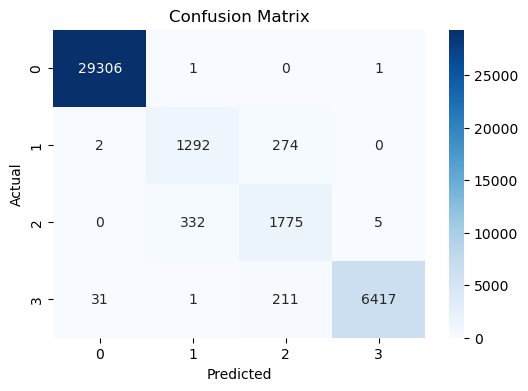

In [69]:
# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

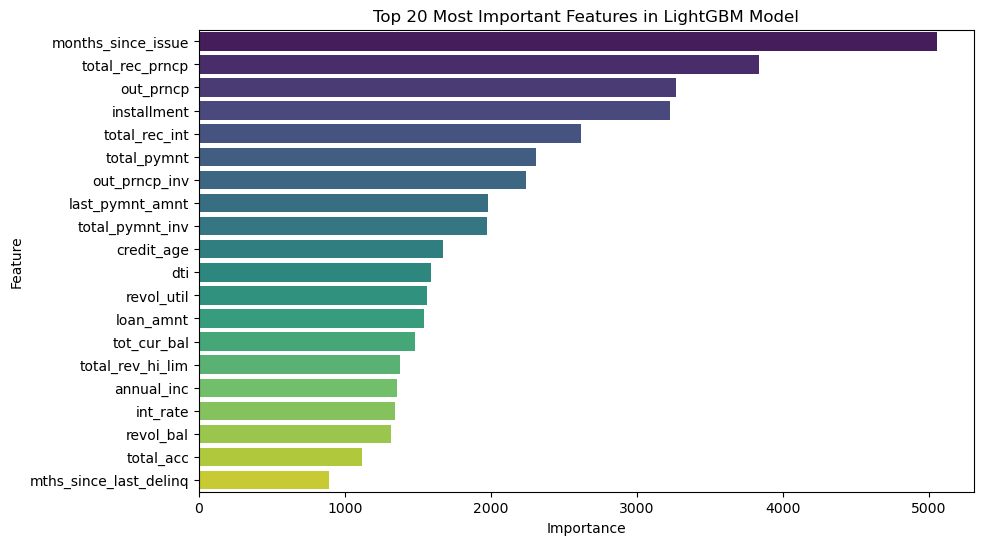

In [70]:
# Get feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': final_lgbm.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20), palette='viridis')
plt.title("Top 20 Most Important Features in LightGBM Model")
plt.show()

# Key Insights from Feature Importance

* “Months Since Issue” (Time since the loan was issued) is the most important factor. -> Conclusion: The longer a loan exists, the clearer its repayment behavior becomes. This suggests that older loans are easier to classify, while new loans need better risk assessment.

* “Total Received Principal” (Total amount repaid) is the 2nd most important feature. -> Conclusion: The amount already repaid is crucial in determining the risk level. Borrowers who have already repaid a significant portion are less risky.

* “Installment Amount” and “Outstanding Principal” are key drivers. ->Conclusion: Borrowers with high installment payments and high outstanding balances tend to fall into higher-risk categories.

* “Loan Amount” matters, but not as much as repayment history! -> Conclusion: A large loan alone does not make a borrower risky—their repayment history and financial behavior are much stronger predictors.

* “Debt-to-Income Ratio (DTI)” and “Revolving Utilization” contribute to risk. -> Conclusion: Higher DTI and credit utilization suggest potential financial stress, increasing the risk of default.

**Recommended Actions Based on Findings**

* (A) Improve risk assessment for new loans (less repayment history)
Use early-stage credit scores and income trends to assess newer loans.
Introduce dynamic risk updating (e.g., after 6 months, re-evaluate risk).

* (B) Focus on payment behavior for existing loans
Customers who start missing payments early should receive immediate intervention.
Offer early repayment incentives for high-risk customers who are still paying.

* (C) Monitor high DTI & revolving credit users more closely
High DTI + high utilization = major risk signals.
Consider offering lower installment restructuring for such borrowers.

# SHAP Analysis

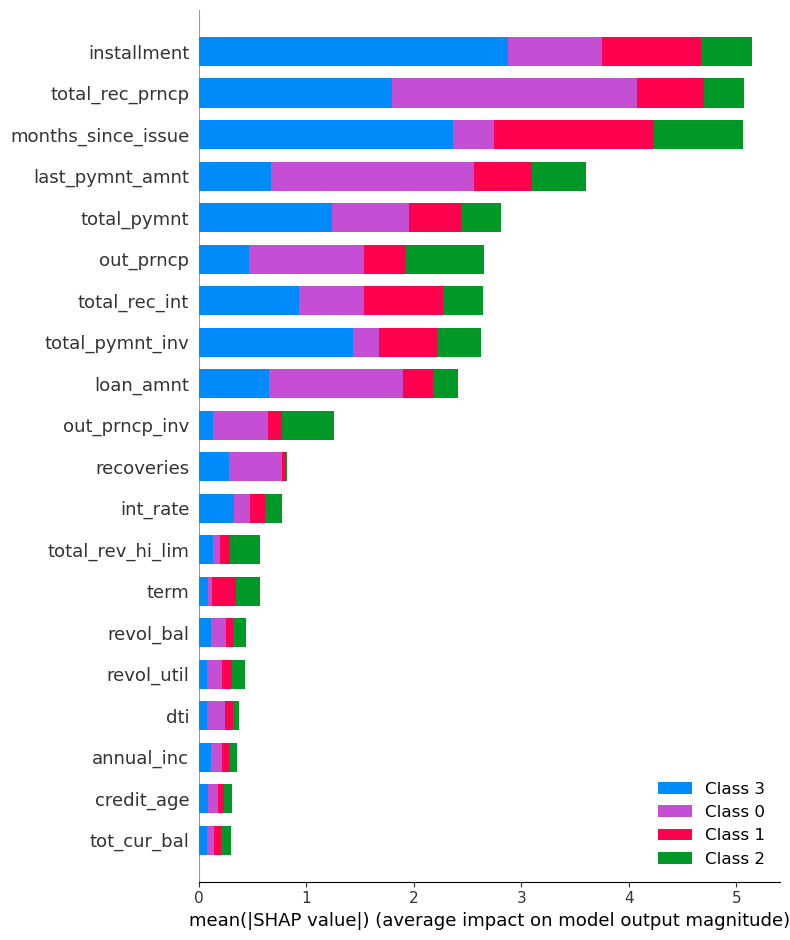

In [74]:
explainer = shap.TreeExplainer(final_lgbm)  # Use TreeExplainer for LightGBM

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

**Top Features & Their Implications¶**

* last_pymnt_amnt (Last Payment Amount) → 🚨 Highly Important
  *  High last payment amounts are strongly correlated with certain loan outcomes.
  *  If a borrower makes a full/large payment, they likely belong to Class 0 (Good loans, Fully Paid, Current).
  *  If payments drop suddenly, it's an early warning for delinquencies.
* total_rec_prncp (Total Principal Received)
  *  Shows how much of the principal has been repaid.
  *  Lower repayments → Higher risk of default (Class 1, 2, 3).
* out_prncp (Outstanding Principal)
  *  Higher remaining balance is a risk factor.
  *  Borrowers with large unpaid balances may struggle with repayments.
* months_since_issue (Time Since Loan Issued)
  *  Older loans → More likely to be fully paid (Class 0).
  *  Recent loans → More uncertain behavior → Spread across different classes.
* installment (Monthly Payment Amount)
  *  Larger installments can signal higher loan sizes → More financial burden.
  *  Risky if combined with high debt-to-income (DTI) ratios.
* loan_amnt (Loan Amount)
  *  Higher loans correlate with higher risk categories (Class 1, 2, 3).
* recoveries (Amount Recovered after Charge-off)
  * This is mainly influencing defaulted loans (Class 3).
* int_rate (Interest Rate)
  *  Higher interest rates typically correlate with higher risk borrowers.
  *  Class 2 & 3 loans (higher risk) see more impact from this.

**What Actions Can We Take?**

* Early Warning System → Track last_pymnt_amnt & out_prncp.
  *  Drop in payments? Alert the collections team
  *  Unpaid balance remains high? Increase risk monitoring.
* Interest Rate Adjustment Strategy
  *  Borrowers with higher loan_amnt → Offer refinancing or restructuring.
  *  Lower-risk customers (based on SHAP) → Better interest rates → Retention.
* Personalized Loan Terms
  *  Adjust installment amounts based on DTI & income insights.

In [75]:
print([col for col in df.columns if 'purpose' in col])

['purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding']


# Loan Risk Analysis

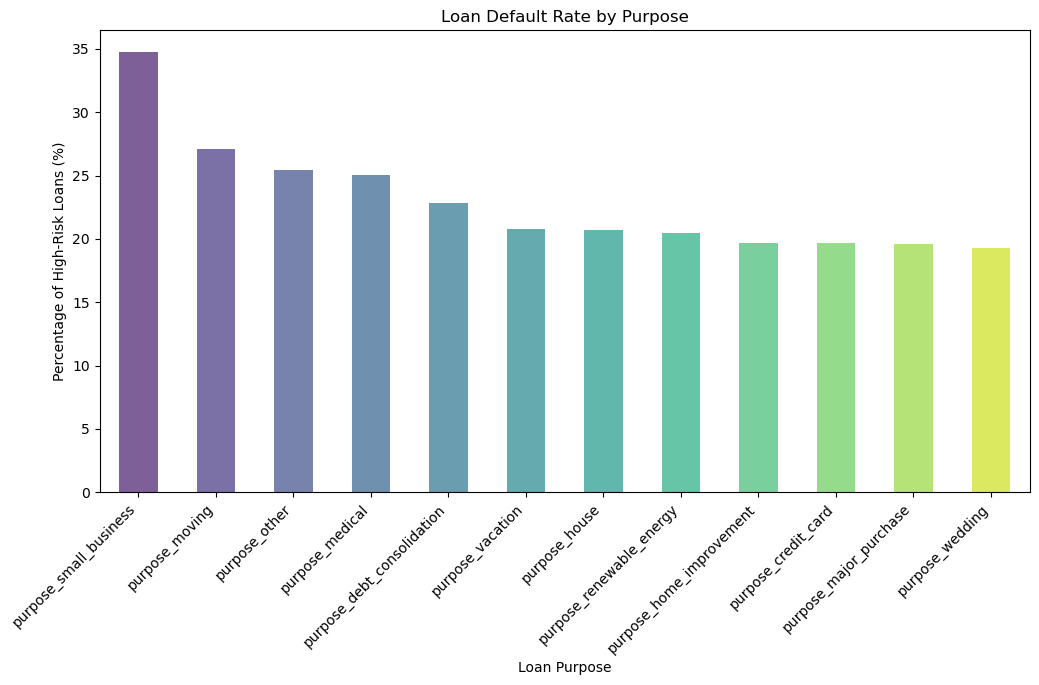

,High-Risk Loan %
purpose_small_business,34.728033
purpose_moving,27.117327
purpose_other,25.427980
purpose_medical,25.065963
purpose_debt_consolidation,22.807586
purpose_vacation,20.758294
purpose_house,20.664207
purpose_renewable_energy,20.437956
purpose_home_improvement,19.693634
purpose_credit_card,19.639225


In [88]:
# High-risk loan classes
high_risk_classes = [2, 3]  # Adjust based on your label definitions

# Select purpose columns
purpose_cols = [col for col in df.columns if 'purpose_' in col]

# Compute the average default rate for each purpose
risk_by_purpose = {}
for col in purpose_cols:
    risk_by_purpose[col] = df.loc[df[col] == 1, 'loan_status'].isin(high_risk_classes).mean() * 100

# Convert to DataFrame
risk_df = pd.DataFrame.from_dict(risk_by_purpose, orient='index', columns=['High-Risk Loan %'])

# Sort and visualize
risk_df = risk_df.sort_values(by='High-Risk Loan %', ascending=False)

plt.figure(figsize=(12,6))
risk_df['High-Risk Loan %'].plot(kind='bar', color=sns.color_palette("viridis", len(risk_df)), alpha=0.7)
plt.ylabel("Percentage of High-Risk Loans (%)")
plt.xlabel("Loan Purpose")
plt.title("Loan Default Rate by Purpose")
plt.xticks(rotation=45, ha="right")
plt.show()

risk_df

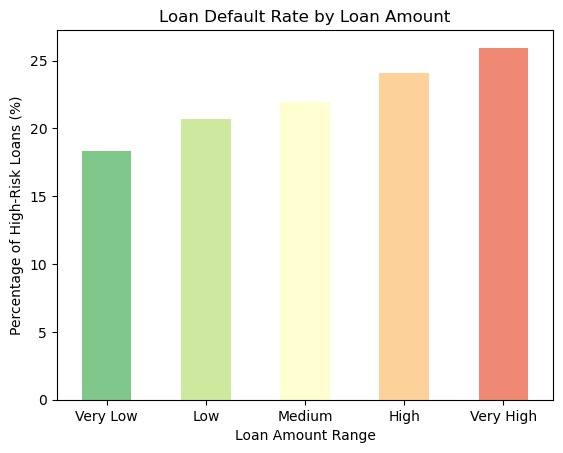

loan_amnt_bin
Very Low     18.333374
Low          20.698890
Medium       21.969082
High         24.056171
Very High    25.955116
Name: loan_status, dtype: float64

In [82]:
# Create loan amount bins
df['loan_amnt_bin'] = pd.qcut(df['loan_amnt'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Calculate default rate per bin
risk_by_loan_amount = df.groupby('loan_amnt_bin')['loan_status'].apply(lambda x: (x.isin(high_risk_classes).mean()) * 100)

# Plot
risk_by_loan_amount.plot(kind='bar', color=sns.color_palette("RdYlGn_r", 5), alpha=0.7)
plt.ylabel("Percentage of High-Risk Loans (%)")
plt.xlabel("Loan Amount Range")
plt.title("Loan Default Rate by Loan Amount")
plt.xticks(rotation=0)
plt.show()

risk_by_loan_amount

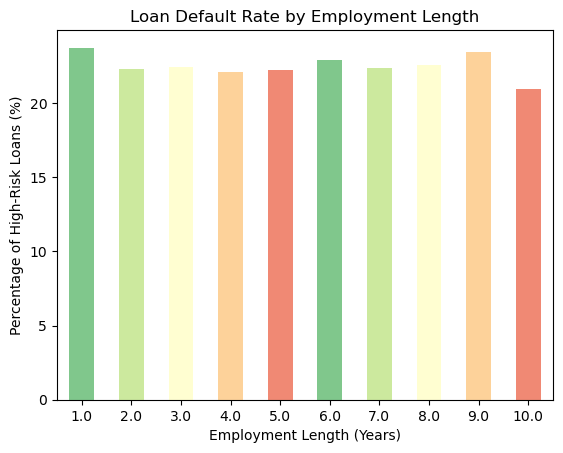

emp_length
1.0     23.730036
2.0     22.270719
3.0     22.433816
4.0     22.080769
5.0     22.194495
6.0     22.871067
7.0     22.340963
8.0     22.536310
9.0     23.413327
10.0    20.916837
Name: loan_status, dtype: float64

In [83]:
# Group by employment length and calculate default rate
risk_by_emp_length = df.groupby('emp_length')['loan_status'].apply(lambda x: (x.isin(high_risk_classes).mean()) * 100)

# Plot
risk_by_emp_length.plot(kind='bar', color=sns.color_palette("RdYlGn_r", 5), alpha=0.7)
plt.ylabel("Percentage of High-Risk Loans (%)")
plt.xlabel("Employment Length (Years)")
plt.title("Loan Default Rate by Employment Length")
plt.xticks(rotation=0)
plt.show()

risk_by_emp_length